In [12]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv("fma-rock-vs-hiphop.csv")

# Read in track metrics with the features
echonest_metrics = pd.read_json("echonest-metrics.json", precise_float=True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = pd.merge(echonest_metrics, tracks[["track_id", "genre_top"]], on="track_id")

# Inspect the resultant frame
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 375.3+ KB


In [13]:
# Define the features
features = echo_tracks.drop(["genre_top","track_id"], axis=1)

# Define the labels
labels = echo_tracks["genre_top"]

# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

[0.24297674 0.18044316 0.13650309 0.12994089 0.11056248 0.08302245
 0.06923783 0.04731336]
8


Text(0.5, 0, 'Principal Component #')

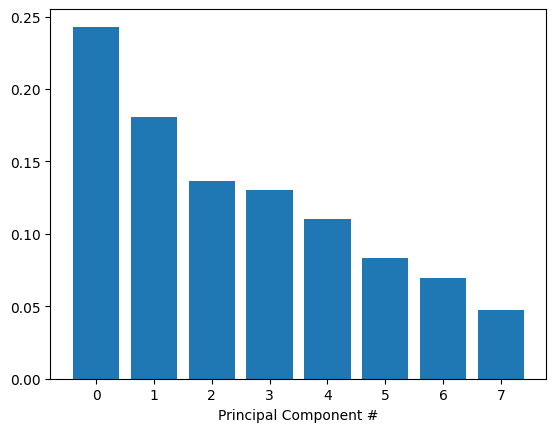

In [15]:
# Import our plotting module, and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

print(pca.explained_variance_ratio_)
print(pca.n_components_)

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(8), exp_variance)
ax.set_xlabel('Principal Component #')

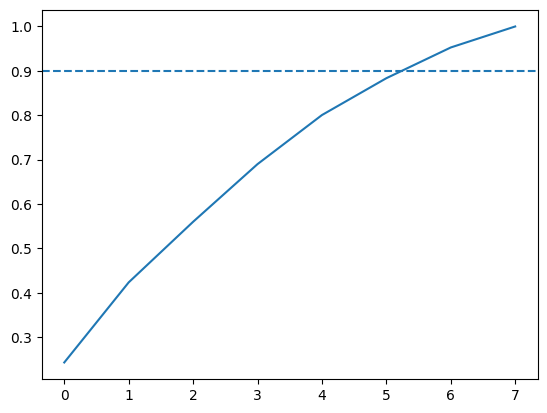

In [17]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.90.
fig, ax = plt.subplots()
ax.plot(range(8), cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

In [19]:
# Import training plit funtion and decision tree classifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)

# Train our decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)

In [20]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



In [23]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks.loc[echo_tracks["genre_top"] == "Hip-Hop"]

# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = echo_tracks.loc[echo_tracks["genre_top"] == "Rock"].sample(len(hop_only), random_state=42)

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only, hop_only])

features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1)
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)

In [25]:
# Train our decision tree on the balanced data
DT = DecisionTreeClassifier(random_state=10)
DT.fit(train_features, train_labels)
pred_labels_tree = DT.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.79      0.79      0.79       230
        Rock       0.78      0.79      0.78       225

    accuracy                           0.79       455
   macro avg       0.79      0.79      0.79       455
weighted avg       0.79      0.79      0.79       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.81      0.80      0.80       230
        Rock       0.79      0.81      0.80       225

    accuracy                           0.80       455
   macro avg       0.80      0.80      0.80       455
weighted avg       0.80      0.80      0.80       455



In [26]:
from sklearn.model_selection import KFold, cross_val_score

# Set up our K-fold cross-validation
kf = KFold(n_splits=10)

DT = DecisionTreeClassifier(random_state=42)
logreg = LogisticRegression(random_state=42)

# Train our models using KFold cv
tree_score = cross_val_score(DT, pca_projection, labels, cv=kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7373626373626374 Logistic Regression: 0.7758241758241757
